In [15]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

SEED=42
cpu=-1
datasetFolder=os.path.dirname(os.getcwd())

def predict_score(model,x_train,y_train,x_test,y_test,name):
    model.fit(x_train,y_train)
    best_pipe=model.best_estimator_
    poly=best_pipe.named_steps["polynomial_features"]
    poly_features=poly.get_feature_names_out(list(x_train.columns))
    selector=best_pipe.named_steps["feature_selection"]
    select_indices=selector.get_support(1)
    select_features=poly_features[select_indices]
    y_predict=model.predict(x_test)
    f1=f1_score(y_test,y_predict)
    auc_score=roc_auc_score(y_test,y_predict)
    return f1,auc_score,select_features
    
def baseDataSet(classFile):
    df=pd.read_csv(classFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","RefusedBequest"]]
    x=df.drop(columns="RefusedBequest")
    y=df[["RefusedBequest"]].values.ravel()
    return x,y

def addMetricsDataSet(classFile):
    df=pd.read_csv(classFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","BOvR_x","ATFD_x","ATLD_x","LAA_x","BUR_x","RefusedBequest"]]
    x=df.drop(columns="RefusedBequest")
    y=df[["RefusedBequest"]].values.ravel()
    return x,y

def baseVersionDataSet(classFile):
    df=pd.read_csv(classFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[["dit_x","fanin_x","fanout_x","lcc_x","lcom*_x","loc_x","noc_x","rfc_x","innerClassesQty_x","totalFieldsQty_x","totalMethodsQty_x","wmc_x","dit_y","fanin_y","fanout_y","lcc_y","lcom*_y","loc_y","noc_y","rfc_y","innerClassesQty_y","totalFieldsQty_y","totalMethodsQty_y","wmc_y","RefusedBequest"]]
    factors=["dit","fanin","fanout","lcc","lcom*","loc","noc","rfc","innerClassesQty","totalFieldsQty","totalMethodsQty","wmc"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="RefusedBequest")
    y=df[["RefusedBequest"]].values.ravel()
    return x,y

def addMetricsVersionDataSet(classFile):
    df=pd.read_csv(classFile,encoding_errors="replace")
    df=df.dropna(how="any")
    df=df[['dit_x', 'fanin_x', 'fanout_x', 'lcc_x', 'lcom*_x', 'loc_x', 'noc_x', 'rfc_x', 'innerClassesQty_x', 'totalFieldsQty_x', 'totalMethodsQty_x', 'wmc_x',  'BOvR_x', 'ATFD_x', 'ATLD_x', 'LAA_x' ,"BUR_x",'dit_y', 'fanin_y', 'fanout_y', 'lcc_y', 'lcom*_y', 'loc_y', 'noc_y', 'rfc_y', 'innerClassesQty_y', 'totalFieldsQty_y', 'totalMethodsQty_y', 'wmc_y', 'BOvR_y', 'ATFD_y', 'ATLD_y', 'LAA_y',"BUR_y","RefusedBequest"]]
    factors=["dit","fanin","fanout","lcc","lcom*","loc","noc","rfc","innerClassesQty","totalFieldsQty","totalMethodsQty","wmc","BUR","BOvR","ATFD","ATLD","LAA"]
    for factor in factors:
        df[factor+"_y"]=df[factor+"_x"]-df[factor+"_y"]
    x=df.drop(columns="RefusedBequest")
    y=df[["RefusedBequest"]].values.ravel()
    return x,y

def overSampling(x_train,y_train):
    x_sampling,y_sampling=SMOTE(sampling_strategy=0.2,random_state=SEED).fit_resample(x_train,y_train)
    return x_sampling,y_sampling

def createTrainTestData(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=SEED)
    x_TrainSampling,y_TrainSampling=overSampling(x_train,y_train)
    return x_TrainSampling,x_test,y_TrainSampling,y_test

In [16]:
RefusedBequestFile=os.path.join(datasetFolder,"dataset2\\RefusedBequest.csv")

x_base,y_base=baseDataSet(RefusedBequestFile)
x_base_train,x_base_test,y_base_train,y_base_test=createTrainTestData(x_base,y_base)
base_score={"f1":[],"auc":[],"feature":[]}

x_add,y_add=addMetricsDataSet(RefusedBequestFile)
x_add_train,x_add_test,y_add_train,y_add_test=createTrainTestData(x_add,y_add)
add_score={"f1":[],"auc":[],"feature":[]}

x_baseVersion,y_baseVersion=baseVersionDataSet(RefusedBequestFile)
x_baseVersion_train,x_baseVersion_test,y_baseVersion_train,y_baseVersion_test=createTrainTestData(x_baseVersion,y_baseVersion)
baseVersion_score={"f1":[],"auc":[],"feature":[]}

x_addVersion,y_addVersion=addMetricsVersionDataSet(RefusedBequestFile)
x_addVersion_train,x_addVersion_test,y_addVersion_train,y_addVersion_test=createTrainTestData(x_addVersion,y_addVersion)
addVersion_score={"f1":[],"auc":[],"feature":[]}


In [17]:
name="DT"
DT_prameter={
    "classifier__criterion":["gini","entropy"],
    "classifier__max_depth":list(range(1,11)),
    "classifier__min_samples_split":list(range(2,21)),
    "classifier__min_samples_leaf":list(range(1,11)),
    "classifier__max_features":["sqrt","log2",None]
    }

k_range=np.arange(1,11,1)
for i in k_range:
    pipline=Pipeline([
        ("polynomial_features",PolynomialFeatures(degree=2)),
        ("minmaxscaler",MinMaxScaler()),
        ("feature_selection",SelectKBest(score_func=f_classif,k=i)),
        ("classifier",DecisionTreeClassifier(random_state=SEED))
    ])
    DT_model=RandomizedSearchCV(pipline, param_distributions=DT_prameter,cv=KFold(n_splits=10,shuffle=True,random_state=SEED),random_state=SEED,n_jobs=cpu)
    print(str(i))
    f1_base,auc_base,feature_base=predict_score(DT_model,x_base_train,y_base_train,x_base_test,y_base_test,name)
    base_score["f1"].append(f1_base)
    base_score["auc"].append(auc_base)
    base_score["feature"].append(feature_base)
    
    f1_add,auc_add,feature_add=predict_score(DT_model,x_add_train,y_add_train,x_add_test,y_add_test,name)
    add_score["f1"].append(f1_add)
    add_score["auc"].append(auc_add)
    add_score["feature"].append(feature_add)
    
    f1_baseVersion,auc_baseVersion,feature_baseVersion=predict_score(DT_model,x_baseVersion_train,y_baseVersion_train,x_baseVersion_test,y_baseVersion_test,name)
    baseVersion_score["f1"].append(f1_baseVersion)
    baseVersion_score["auc"].append(auc_baseVersion)
    baseVersion_score["feature"].append(feature_baseVersion)

    f1_addVersion,auc_addVersion,feature_addVersion=predict_score(DT_model,x_addVersion_train,y_addVersion_train,x_addVersion_test,y_addVersion_test,name)
    addVersion_score["f1"].append(f1_addVersion)
    addVersion_score["auc"].append(auc_addVersion)   
    addVersion_score["feature"].append(feature_addVersion)

    #features_baselist.append(baseDF.columns[features_base])
    #features_addlist.append(addMetricsDF.columns[features_add])


1


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

2


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

3


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

4


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

5


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

6


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

7


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

8


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

9


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

10


c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\sugii syuji\AppData\Local\Programs\Python\Python313\Lib\site-packages\s

In [1]:
import matplotlib.pyplot as plt

x=k_range
plt.title("F1")
plt.plot(x,base_score["f1"],label="base")
plt.plot(x,add_score["f1"],label="add")
plt.plot(x,baseVersion_score["f1"],label="baseVersion")
plt.plot(x,addVersion_score["f1"],label="addVersion")
plt.legend()
plt.show()

plt.title("RefusedBequest_AUC")
plt.plot(x,base_score["auc"],label="base")
plt.plot(x,add_score["auc"],label="add")
plt.plot(x,baseVersion_score["auc"],label="baseVersion")
plt.plot(x,addVersion_score["auc"],label="addVersion")
plt.legend()
plt.show()

NameError: name 'k_range' is not defined

In [19]:
print(base_score)
print(add_score)
print(baseVersion_score)
print(addVersion_score)

{'f1': [0.02608695652173913, 0.07909604519774012, 0.08648648648648649, 0.105, 0.08928571428571429, 0.13333333333333333, 0.13937282229965156, 0.1157556270096463, 0.12318840579710146, 0.125], 'auc': [np.float64(0.51819327672895), np.float64(0.6287588126930481), np.float64(0.6493829383492389), np.float64(0.7017396844744241), np.float64(0.6869676025319612), np.float64(0.6890002354668477), np.float64(0.699790157485768), np.float64(0.6759803038907434), np.float64(0.6678186074213609), np.float64(0.7261866836572156)], 'feature': [array(['rfc_x'], dtype=object), array(['dit_x', 'rfc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x', 'lcc_x totalMethodsQty_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_

{'f1': [0.02608695652173913, 0.07909604519774012, 0.08648648648648649, 0.105, 0.08928571428571429, 0.13333333333333333, 0.13937282229965156, 0.1157556270096463, 0.12318840579710146, 0.125], 'auc': [np.float64(0.51819327672895), np.float64(0.6287588126930481), np.float64(0.6493829383492389), np.float64(0.7017396844744241), np.float64(0.6869676025319612), np.float64(0.6890002354668477), np.float64(0.699790157485768), np.float64(0.6759803038907434), np.float64(0.6678186074213609), np.float64(0.7261866836572156)], 'feature': [array(['rfc_x'], dtype=object), array(['dit_x', 'rfc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x', 'lcc_x totalMethodsQty_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'fanout_x lcom*_x', 'lcc_x rfc_x', 'lcc_x totalMethodsQty_x',
       'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'wmc_x', 'dit_x lcc_x',
       'dit_x lcom*_x', 'fanout_x lcom*_x', 'lcc_x rfc_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object)]}

{'f1': [0.2100456621004566, 0.16447368421052633, 0.17647058823529413, 0.18326693227091634, 0.18892508143322476, 0.2230769230769231, 0.22556390977443608, 0.23577235772357724, 0.23478260869565218, 0.22510822510822512], 'auc': [np.float64(0.7380535202293725), np.float64(0.7531822651910743), np.float64(0.714641882626702), np.float64(0.7355049378783052), np.float64(0.7967401692591106), np.float64(0.8004833995872406), np.float64(0.8109547488122775), np.float64(0.8015984043658325), np.float64(0.7809742787096416), np.float64(0.7699454270953086)], 'feature': [array(['BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['rfc_x', 'BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'],
      dtype=object), array(['rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x', 'BOvR_x^2',
       'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'lcom*_x BOvR_x',
       'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'BUR_x', 'dit_x LAA_x',
       'lcom*_x BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x',
       'BUR_x^2'], dtype=object)]}

{'f1': [0.02608695652173913, 0.06976744186046512, 0.08648648648648649, 0.07920792079207921, 0.08, 0.13256484149855907, 0.13813813813813813, 0.13333333333333333, 0.1282051282051282, 0.11003236245954692], 'auc': [np.float64(0.51819327672895), np.float64(0.6076568278460325), np.float64(0.6493829383492389), np.float64(0.64667506960123), np.float64(0.6649098993032951), np.float64(0.7278591908251035), np.float64(0.7289741956036954), np.float64(0.7182639167832459), np.float64(0.6977990775239968), np.float64(0.6651903818718229)], 'feature': [array(['rfc_x'], dtype=object), array(['dit_x', 'rfc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'fanout_x lcom*_x', 'lcc_x rfc_x', 'lcc_x totalMethodsQty_x',
       'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'wmc_x', 'dit_x lcc_x',
       'dit_x lcom*_x', 'fanout_x lcom*_x', 'lcc_x rfc_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object)]}

{'f1': [0.20444444444444446, 0.1566265060240964, 0.17073170731707318, 0.16153846153846155, 0.2033898305084746, 0.23076923076923078, 0.22627737226277372, 0.24691358024691357, 0.2288135593220339, 0.22784810126582278], 'auc': [np.float64(0.7375756610385473), np.float64(0.7619014640497527), np.float64(0.7140047370389352), np.float64(0.7128897322603432), np.float64(0.8086450960566229), np.float64(0.8114326080031026), np.float64(0.8212668116403729), np.float64(0.8127865423771071), np.float64(0.7804964195188165), np.float64(0.7804167763203457)], 'feature': [array(['BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['rfc_x', 'BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'],
      dtype=object), array(['rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x', 'BOvR_x^2',
       'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'lcom*_x BOvR_x',
       'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'BUR_x', 'dit_x LAA_x',
       'lcom*_x BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x',
       'BUR_x^2'], dtype=object)]}

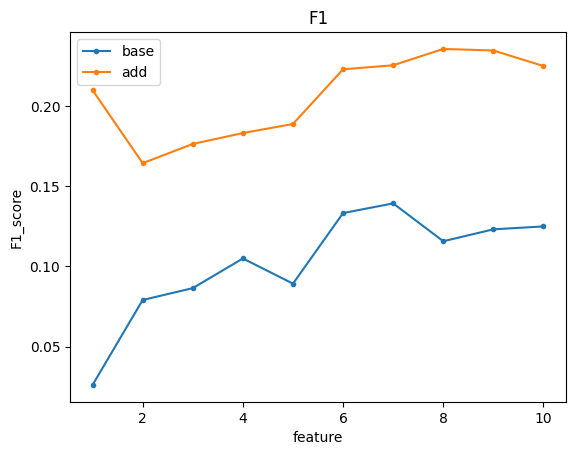

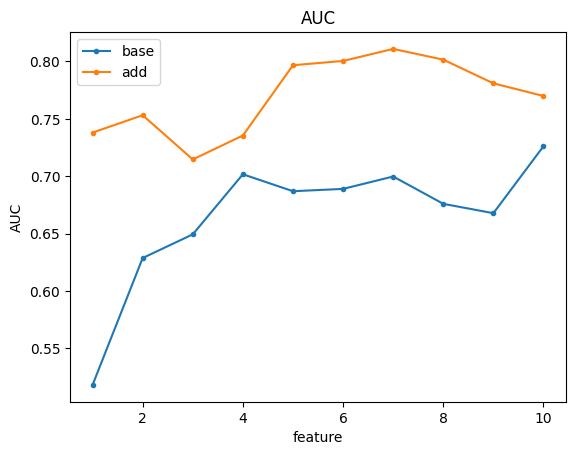

In [2]:
import numpy as np
import matplotlib.pyplot as plt
base_score={'f1': [0.02608695652173913, 0.07909604519774012, 0.08648648648648649, 0.105, 0.08928571428571429, 0.13333333333333333, 0.13937282229965156, 0.1157556270096463, 0.12318840579710146, 0.125], 'auc': [np.float64(0.51819327672895), np.float64(0.6287588126930481), np.float64(0.6493829383492389), np.float64(0.7017396844744241), np.float64(0.6869676025319612), np.float64(0.6890002354668477), np.float64(0.699790157485768), np.float64(0.6759803038907434), np.float64(0.6678186074213609), np.float64(0.7261866836572156)]}
add_score={'f1': [0.2100456621004566, 0.16447368421052633, 0.17647058823529413, 0.18326693227091634, 0.18892508143322476, 0.2230769230769231, 0.22556390977443608, 0.23577235772357724, 0.23478260869565218, 0.22510822510822512], 'auc': [np.float64(0.7380535202293725), np.float64(0.7531822651910743), np.float64(0.714641882626702), np.float64(0.7355049378783052), np.float64(0.7967401692591106), np.float64(0.8004833995872406), np.float64(0.8109547488122775), np.float64(0.8015984043658325), np.float64(0.7809742787096416), np.float64(0.7699454270953086)]}
baseVersion_score={'f1': [0.02608695652173913, 0.06976744186046512, 0.08648648648648649, 0.07920792079207921, 0.08, 0.13256484149855907, 0.13813813813813813, 0.13333333333333333, 0.1282051282051282, 0.11003236245954692], 'auc': [np.float64(0.51819327672895), np.float64(0.6076568278460325), np.float64(0.6493829383492389), np.float64(0.64667506960123), np.float64(0.6649098993032951), np.float64(0.7278591908251035), np.float64(0.7289741956036954), np.float64(0.7182639167832459), np.float64(0.6977990775239968), np.float64(0.6651903818718229)]}
addVersion_score={'f1': [0.20444444444444446, 0.1566265060240964, 0.17073170731707318, 0.16153846153846155, 0.2033898305084746, 0.23076923076923078, 0.22627737226277372, 0.24691358024691357, 0.2288135593220339, 0.22784810126582278], 'auc': [np.float64(0.7375756610385473), np.float64(0.7619014640497527), np.float64(0.7140047370389352), np.float64(0.7128897322603432), np.float64(0.8086450960566229), np.float64(0.8114326080031026), np.float64(0.8212668116403729), np.float64(0.8127865423771071), np.float64(0.7804964195188165), np.float64(0.7804167763203457)]}
x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base_score["f1"],label="base",marker=".")
plt.plot(x,add_score["f1"],label="add",marker=".")
#plt.plot(x,baseVersion_score["f1"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base_score["auc"],label="base",marker=".")
plt.plot(x,add_score["auc"],label="add",marker=".")
#plt.plot(x,baseVersion_score["auc"],label="baseVersion",linestyle="dashed",marker="v")
#plt.plot(x,addVersion_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()

f1
base :  0.08928571428571429
add :  0.18892508143322476
baseVersion :  0.08
auc
base :  0.6869676025319612
add :  0.7967401692591106
baseVersion :  0.6649098993032951
feature
base :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x' 'lcc_x totalMethodsQty_x']
add :  ['rfc_x' 'BOvR_x' 'rfc_x LAA_x' 'BOvR_x^2' 'BOvR_x BUR_x']
baseVersion :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x' 'lcc_x totalMethodsQty_x']
base        :  ['rfc_x']
baseVersion :  ['rfc_x']
base        :  ['dit_x' 'rfc_x']
baseVersion :  ['dit_x' 'rfc_x']
base        :  ['dit_x' 'rfc_x' 'dit_x lcc_x']
baseVersion :  ['dit_x' 'rfc_x' 'dit_x lcc_x']
base        :  ['dit_x' 'rfc_x' 'dit_x lcc_x' 'lcc_x totalMethodsQty_x']
baseVersion :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x']
base        :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x' 'lcc_x totalMethodsQty_x']
baseVersion :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x' 'lcc_x totalMethodsQty_x']
base        :  ['dit_x' 'fanout_x' 'rfc_x' 'dit_x lcc_x' 'dit_x lcom*_x'
 'lcc_x totalM

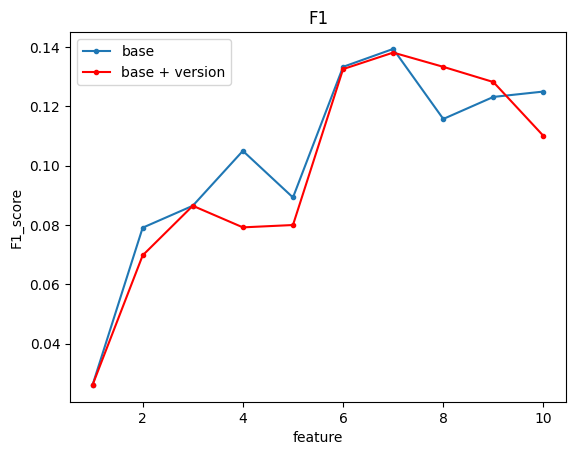

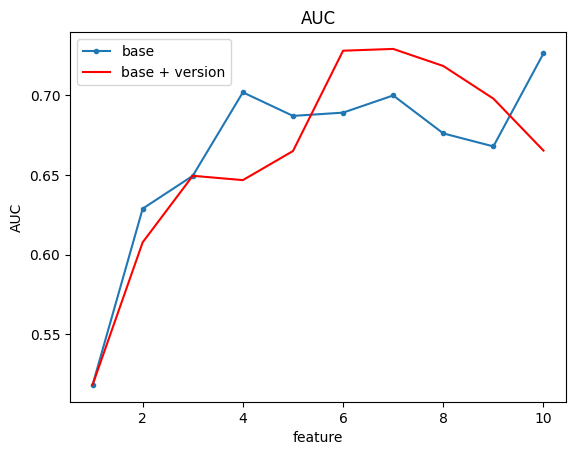

In [6]:
from numpy import array


base1_score={'f1': [0.02608695652173913, 0.07909604519774012, 0.08648648648648649, 0.105, 0.08928571428571429, 0.13333333333333333, 0.13937282229965156, 0.1157556270096463, 0.12318840579710146, 0.125], 'auc': [np.float64(0.51819327672895), np.float64(0.6287588126930481), np.float64(0.6493829383492389), np.float64(0.7017396844744241), np.float64(0.6869676025319612), np.float64(0.6890002354668477), np.float64(0.699790157485768), np.float64(0.6759803038907434), np.float64(0.6678186074213609), np.float64(0.7261866836572156)], 'feature': [array(['rfc_x'], dtype=object), array(['dit_x', 'rfc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x', 'lcc_x totalMethodsQty_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'fanout_x lcom*_x', 'lcc_x rfc_x', 'lcc_x totalMethodsQty_x',
       'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'wmc_x', 'dit_x lcc_x',
       'dit_x lcom*_x', 'fanout_x lcom*_x', 'lcc_x rfc_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object)]}

add1_score={'f1': [0.2100456621004566, 0.16447368421052633, 0.17647058823529413, 0.18326693227091634, 0.18892508143322476, 0.2230769230769231, 0.22556390977443608, 0.23577235772357724, 0.23478260869565218, 0.22510822510822512], 'auc': [np.float64(0.7380535202293725), np.float64(0.7531822651910743), np.float64(0.714641882626702), np.float64(0.7355049378783052), np.float64(0.7967401692591106), np.float64(0.8004833995872406), np.float64(0.8109547488122775), np.float64(0.8015984043658325), np.float64(0.7809742787096416), np.float64(0.7699454270953086)], 'feature': [array(['BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['rfc_x', 'BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'],
      dtype=object), array(['rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x', 'BOvR_x^2',
       'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'lcom*_x BOvR_x',
       'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'BUR_x', 'dit_x LAA_x',
       'lcom*_x BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x',
       'BUR_x^2'], dtype=object)]}

baseVersion1_score={'f1': [0.02608695652173913, 0.06976744186046512, 0.08648648648648649, 0.07920792079207921, 0.08, 0.13256484149855907, 0.13813813813813813, 0.13333333333333333, 0.1282051282051282, 0.11003236245954692], 'auc': [np.float64(0.51819327672895), np.float64(0.6076568278460325), np.float64(0.6493829383492389), np.float64(0.64667506960123), np.float64(0.6649098993032951), np.float64(0.7278591908251035), np.float64(0.7289741956036954), np.float64(0.7182639167832459), np.float64(0.6977990775239968), np.float64(0.6651903818718229)], 'feature': [array(['rfc_x'], dtype=object), array(['dit_x', 'rfc_x'], dtype=object), array(['dit_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'lcc_x rfc_x', 'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'],
      dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'dit_x lcc_x', 'dit_x lcom*_x',
       'fanout_x lcom*_x', 'lcc_x rfc_x', 'lcc_x totalMethodsQty_x',
       'lcom*_x rfc_x'], dtype=object), array(['dit_x', 'fanout_x', 'rfc_x', 'wmc_x', 'dit_x lcc_x',
       'dit_x lcom*_x', 'fanout_x lcom*_x', 'lcc_x rfc_x',
       'lcc_x totalMethodsQty_x', 'lcom*_x rfc_x'], dtype=object)]}

addVersion1_score={'f1': [0.20444444444444446, 0.1566265060240964, 0.17073170731707318, 0.16153846153846155, 0.2033898305084746, 0.23076923076923078, 0.22627737226277372, 0.24691358024691357, 0.2288135593220339, 0.22784810126582278], 'auc': [np.float64(0.7375756610385473), np.float64(0.7619014640497527), np.float64(0.7140047370389352), np.float64(0.7128897322603432), np.float64(0.8086450960566229), np.float64(0.8114326080031026), np.float64(0.8212668116403729), np.float64(0.8127865423771071), np.float64(0.7804964195188165), np.float64(0.7804167763203457)], 'feature': [array(['BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2'], dtype=object), array(['rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['rfc_x', 'BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x'],
      dtype=object), array(['rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x', 'BOvR_x^2',
       'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'rfc_x LAA_x',
       'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'dit_x LAA_x', 'lcom*_x BOvR_x',
       'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x', 'BUR_x^2'], dtype=object), array(['dit_x', 'rfc_x', 'BOvR_x', 'BUR_x', 'dit_x LAA_x',
       'lcom*_x BOvR_x', 'rfc_x LAA_x', 'BOvR_x^2', 'BOvR_x BUR_x',
       'BUR_x^2'], dtype=object)]}

factors=["f1","auc","feature"]
for factor in factors:
    print(factor)
    print("base : ",base1_score[factor][4])
    print("add : ",add1_score[factor][4])
    print("baseVersion : ",baseVersion1_score[factor][4])

for i in range(10):
    print("base        : ",base1_score["feature"][i])
    print("baseVersion : ",baseVersion1_score["feature"][i])

x=np.arange(1,11,1)
plt.title("F1")
plt.xlabel("feature")
plt.ylabel("F1_score")
plt.plot(x,base1_score["f1"],label="base",marker=".")
#plt.plot(x,add1_score["f1"],label="add",marker=".")
plt.plot(x,baseVersion1_score["f1"],label="base + version",marker=".",color="red")
#plt.plot(x,addVersion1_score["f1"],label="addVersion",linestyle="dashed",marker="v")
plt.legend()
plt.show()

plt.title("AUC")
plt.xlabel("feature")
plt.ylabel("AUC")
plt.plot(x,base_score["auc"],label="base",marker=".")
#plt.plot(x,add_score["auc"],label="add",marker=".")
plt.plot(x,baseVersion1_score["auc"],label="base + version",color="red")
#plt.plot(x,addVersion1_score["auc"],label="addVersion",linestyle="dashdot",marker="v")
plt.legend()
plt.show()